# GFs for MNIST (Multiscale)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

# Plot utilities
from rbig_jax.custom_types import ImageShape
from rbig_jax.plots import plot_image_grid


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
import wandb

wandb_logger = wandb.init(project="gf_mnist_naive", entity="ipl_uv")

wandb_logger.config.seed = 123

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Demo Data

In this demonstration, we will be using the "mnist" dataset.

In [4]:
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

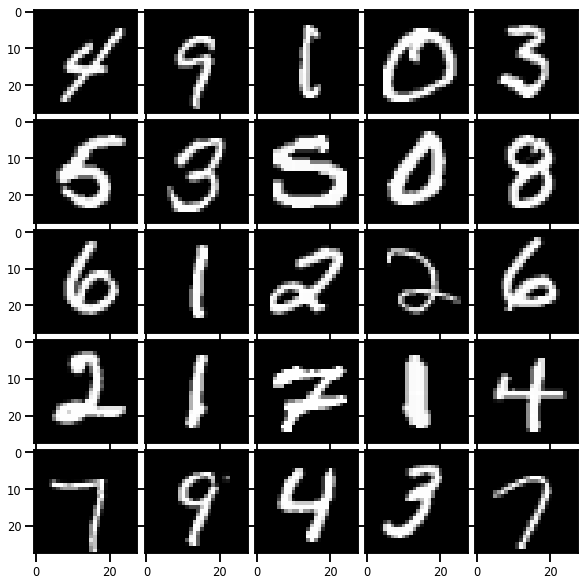

In [5]:
# train/valid dataset loaders
wandb_logger.config.batch_size = 128
n_init_samples = 1_000
train_ds = load_dataset(tfds.Split.TRAIN, 128)
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
valid_ds = load_dataset(tfds.Split.TEST, 128)

# demo batch
demo_batch = next(train_ds)

# plot batch of images
fig, ax = plot_image_grid(demo_batch["image"])

wandb.log({"demo_images": wandb.Image(plt)})

### Preprocessing Steps

1. Dequantize the variables

Basically add some uniform noise to help with training.

2. Normalize the pixels

We constrain the pixels to be from $[0, 256)$ to $[0, 1)$.

In [6]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:

    # select image from tfds
    data = batch["image"].astype(jnp.float32)

    # dequantize pixels (training only)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape)

    # flatten image data
    data = rearrange(data, "B H W C -> B (H W C)")

    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

#### Demo

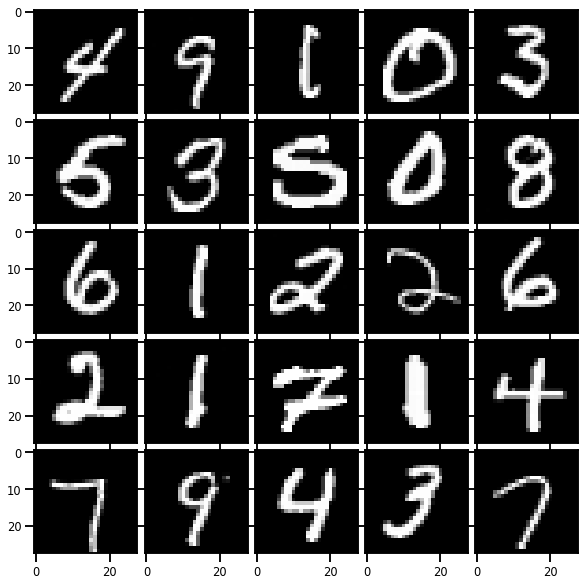

In [7]:
# create key
rng, prng_key = jax.random.split(KEY, num=2)

# prep the data
demo_data_prepped = prepare_data(demo_batch, prng_key=prng_key)

# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
fig, ax = plot_image_grid(demo_data_prepped, image_shape)

wandb.log({"demo_images_prepped": wandb.Image(plt)})

## Model

### Layers

In [8]:
from rbig_jax.transforms.parametric.splines import InitPiecewiseRationalQuadraticCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder

# parameters
n_bins = 32
range_min = -10
range_max = 10
boundary_slopes = "identity"
identity_init = False

init_rq_f = InitPiecewiseRationalQuadraticCDF(
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
)

# Householder Transformation
n_reflections = 50
method = "random"

# initialize init function
init_hh_f = InitHouseHolder(n_reflections=n_reflections, method=method)

### Init MultiScale Layer

#### Initial Data

In [9]:
# initialization data
n_init_samples = 100

init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
init_ds = next(init_ds)
init_data_prepped = prepare_data(init_ds, prng_key=prng_key)

rng, irng_init = jax.random.split(rng, num=2)
X_g_subset = jax.random.permutation(rng, init_data_prepped)[:n_init_samples]

(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7fd81c472820>)

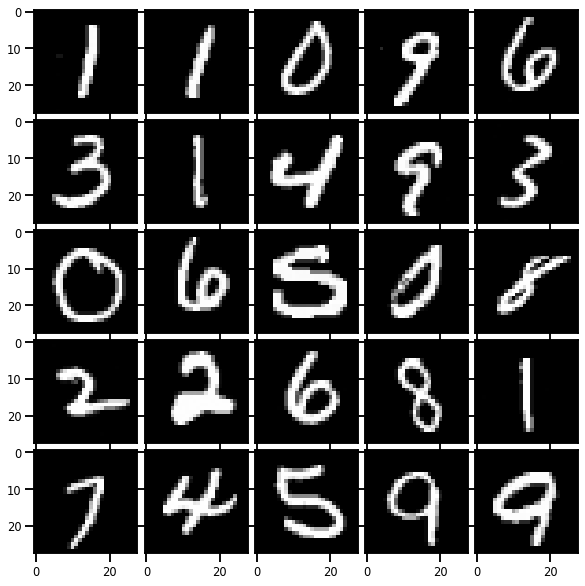

In [10]:
plot_image_grid(X_g_subset, image_shape)

#### Scales

In [11]:
# filters = [(2, 2), (4, 4), (8, 8,), (16, 16), (32, 32)]
filters = [(2, 2), (4, 4), (7, 7,), (14, 14)]
n_filters = len(filters)

#### Init Loop

In [12]:
from rbig_jax.transforms.reshape import init_scale_function
from rbig_jax.transforms.multiscale import MultiScaleBijector
from rbig_jax.transforms.base import BijectorChain

In [13]:
from rbig_jax.transforms.multiscale import RescaleParams


def init_rescale_params(filter_shape, image_shape):
    fh, fw = filter_shape
    H = image_shape.H
    W = image_shape.W
    C = image_shape.C
    #     # do some checks!
    #     assert H / fh !% 0
    #     assert W / fw !% 0

    Hn = H // fh
    Wn = W // fw

    rescale_params = RescaleParams(fh=fh, fw=fw, H=H, W=W, C=C, Hn=Hn, Wn=Wn,)
    return rescale_params

In [14]:
# Layer Params
n_sub_layers = 4


# Plotting
plot_layers = False
plot_intermediates = False

ms_bijectors = []
j = 0

X_g_subset_ = X_g_subset.copy()

with tqdm.tqdm(filters) as pbar:

    # Loop through the scales
    for i, i_filter in enumerate(pbar):

        pbar.set_description(
            f"Filter: {i_filter} - Layer: {i} - X: {X_g_subset_.shape}- Initializing MixCDF"
        )

        # split keys for sublayer params
        rng, ilayer_rngs = jax.random.split(rng, num=2)

        bijectors = []

        ms_reshape = init_scale_function(i_filter, image_shape, batch=False)

        X_g_subset_ = ms_reshape.forward(X_g_subset_)
        
        # loop through the layers
        for j, irng in enumerate(ilayer_rngs):

            # ======================
            # Rational Quadratic
            # ======================
            # create keys for all inits
            pbar.set_description(
                f"Filter: {i_filter} - Layer: {j} - X: {X_g_subset_.shape}- Initializing MixCDF"
            )
            ilayer_rngs, i_rq_rng = jax.random.split(ilayer_rngs, 2)

            # intialize bijector and transformation
            X_g_subset_, layer = init_rq_f.bijector_and_transform(
                inputs=X_g_subset_, rng=i_rq_rng, shape=X_g_subset_.shape[1:]
            )

            # plot data
            if plot_layers and plot_intermediates:
                fig = corner.corner(X_g_subset_, color="red", hist_bin_factor=2)

            # add bijector to list
            bijectors.append(layer)

            # ======================
            # HOUSEHOLDER
            # ======================
            pbar.set_description(
                f"Filter: {i_filter} - Layer: {j} - X: {X_g_subset_.shape}- HouseHolder"
            )
            # create keys for all inits
            ilayer_rngs, hh_rng = jax.random.split(ilayer_rngs, 2)

            # intialize bijector and transformation
            X_g_subset_, layer = init_hh_f.bijector_and_transform(
                inputs=X_g_subset_, rng=hh_rng, n_features=X_g_subset_.shape[1]
            )

            bijectors.append(layer)

            # plot data
            if plot_layers:
                plot_image_grid(X_g_subset_, image_shape)
        #                 fig = corner.corner(X_g, color="red", hist_bin_factor=2)

        # create bijector chain
        bijector_chain = BijectorChain(bijectors=bijectors)

        # initialize multiscale bijector
        rescale_params = init_scale_function(i_filter, image_shape, batch=False)
        ms_bijector = MultiScaleBijector(
            bijectors=bijector_chain,
            squeeze=rescale_params.forward,
            unsqueeze=rescale_params.inverse,
            #             batch=False,
        )
        #         ms_bijector = MultiScaleBijector(
        #             bijectors=bijector_chain,
        #             rescale_params=init_rescale_params(i_filter, image_shape),
        #         )

        ms_bijectors.append(ms_bijector)

        X_g_subset_ = ms_reshape.inverse(X_g_subset_)

Filter: (14, 14) - Layer: 1 - X: (400, 196)- HouseHolder: 100%|██████████| 4/4 [00:15<00:00,  3.83s/it]        


## Final Model

In [15]:
from rbig_jax.models import GaussianizationFlow
from distrax._src.distributions.normal import Normal

In [16]:
# initialize base distribution
base_dist = Normal(0.0, 1.0)

# initialize model
gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=ms_bijectors)

### Demo Transformation

#### Forward

In [17]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(demo_data_prepped[:50])

CPU times: user 5.69 s, sys: 137 ms, total: 5.82 s
Wall time: 5.49 s


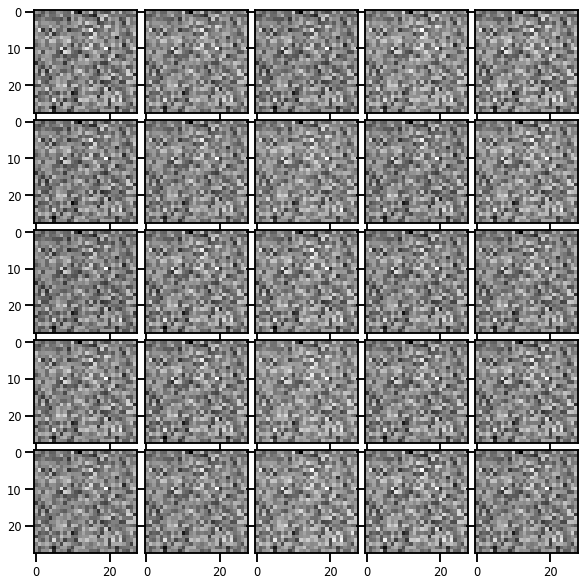

In [18]:
# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"initial_latent_images": wandb.Image(plt)})

#### Inverse

In [19]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g)

CPU times: user 3.17 s, sys: 95.7 ms, total: 3.27 s
Wall time: 2.97 s


(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7fd7b86eda00>)

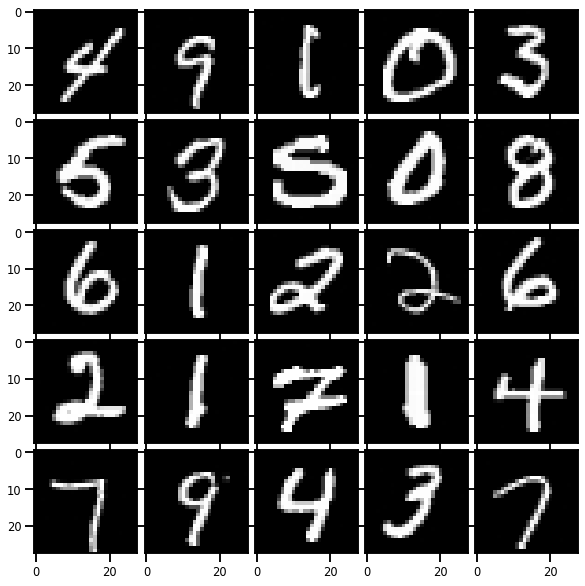

In [20]:
# plot demo images
plot_image_grid(X_demo_approx, image_shape)

### Loss Function

We're going to minimize the log probability

In [21]:
from chex import dataclass


def loss_fn(model: dataclass, prng_key: PRNGKey, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch, prng_key)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss


def eval_fn(model: dataclass, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss

#### Demo

In [22]:
nll_loss = loss_fn(gf_model, prng_key, demo_batch)
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

nll_loss_val = eval_fn(gf_model, demo_batch)

print(f"Initial NLL Loss (Valid): {nll_loss_val:.4f}")

Initial NLL Loss (Train): 3662.9431
Initial NLL Loss (Valid): 3661.3628


## Training

### Optimizer

In [23]:
import optax

# optimizer params
learning_rate = 1e-3

# intialize optimizer
optimizer = optax.adam(learning_rate=learning_rate)

# intialize optimizer state
opt_state = optimizer.init(gf_model)

### Train Step

In [24]:
from typing import Tuple, Any

OptState = Any


@jax.jit
def update(
    params: dataclass, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, prng_key, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Training Loop

In [25]:
# number of epochs
epochs = 5_000
eval_frequency = 100
# split the keys into a unique subset
train_rng = jax.random.split(rng, num=epochs)

# create an iterator
train_rng = iter(train_rng)

In [26]:
%%wandb

import tqdm


losses = []
valid_losses = []
eval_loss = 0.0
with tqdm.trange(epochs) as pbar:
    for step in pbar:
        gf_model, opt_state, loss = update(
            gf_model, next(train_rng), opt_state, next(train_ds)
        )

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        wandb.log({"train_loss": float(loss), "training_step": step})
        losses.append(loss)
        
        if step % eval_frequency == 0:
            eval_loss = eval_fn(gf_model, next(valid_ds))
            valid_losses.append(eval_loss)
            pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
            wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            losses.append(loss)

Train Loss: nan | Valid Loss: nan: 100%|██████████| 5000/5000 [43:25<00:00,  1.92it/s]                


#### Losses

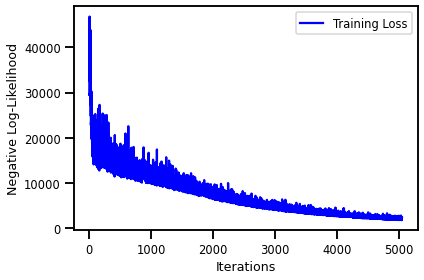

In [22]:
fig, ax = plt.subplots()
ax.plot(losses, label="Training Loss", color="blue")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

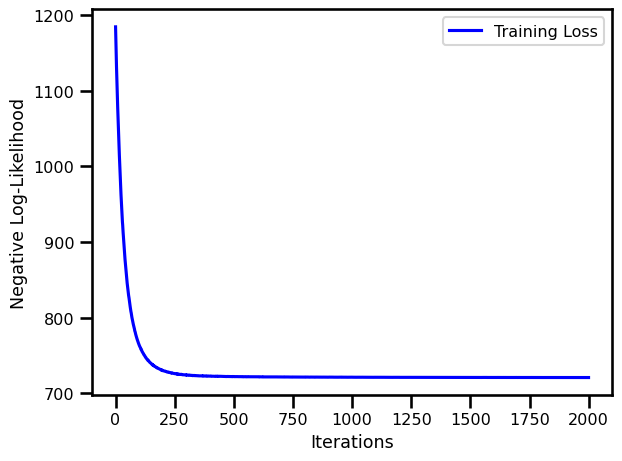

In [72]:
fig, ax = plt.subplots()
ax.plot(losses, label="Training Loss", color="blue")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

CPU times: user 4.39 s, sys: 91.6 ms, total: 4.48 s
Wall time: 4.09 s


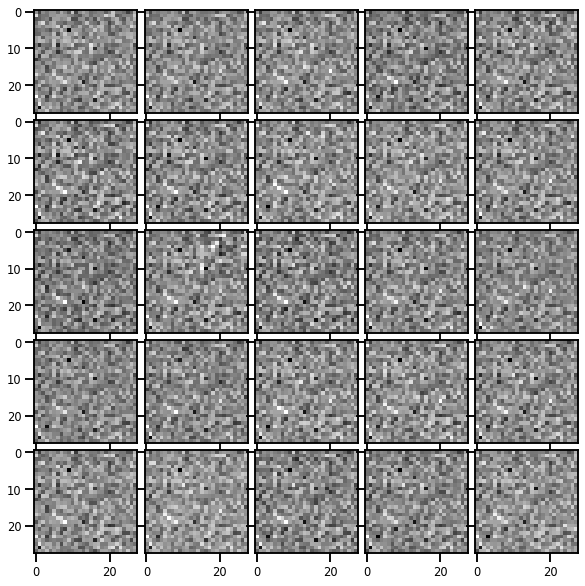

In [28]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(X_g_subset_)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"final_latent_images": wandb.Image(plt)})

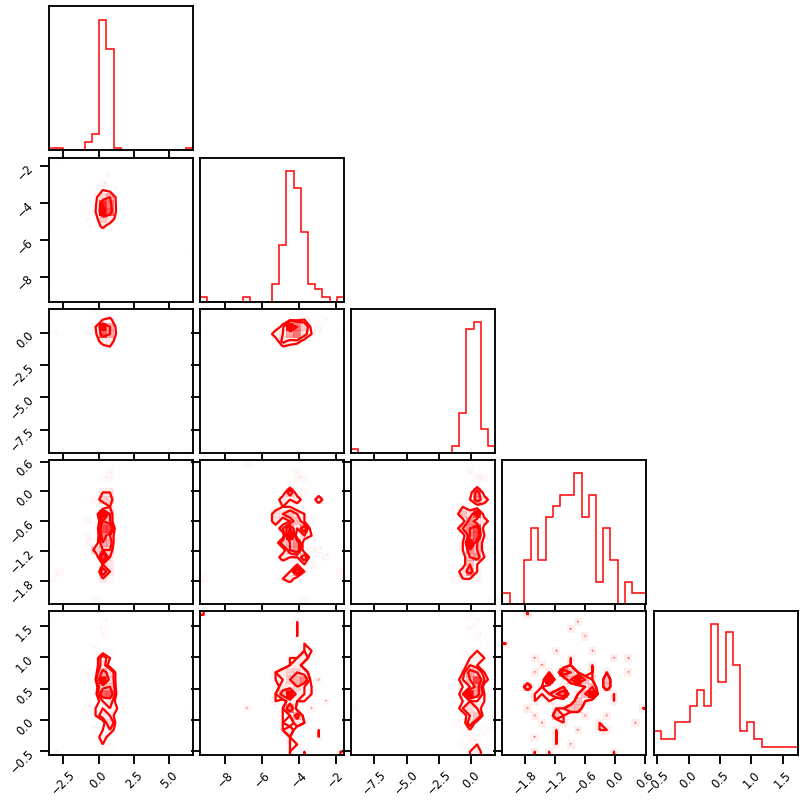

In [29]:
fig = corner.corner(np.array(X_demo_g[:, :5]), color="red")
wandb.log({"final_latent_histogram": wandb.Image(plt)})

CPU times: user 4.88 s, sys: 102 ms, total: 4.98 s
Wall time: 4.68 s


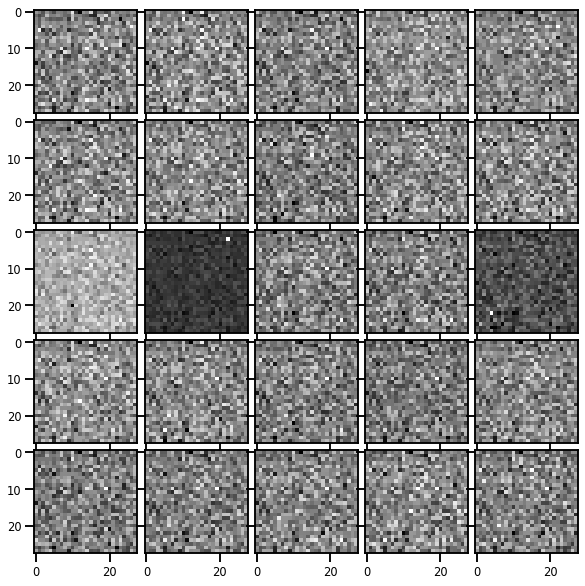

In [30]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g[:50])

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_approx, image_shape)
# plot image grid

wandb.log({"inverse_transform_images": wandb.Image(plt)})

### Sampling

In [31]:
%%time

n_gen_samples = 50
X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

# plot
fig, ax = plot_image_grid(X_samples, image_shape)

wandb.log({"generated_samples_images": wandb.Image(plt)})

EinopsError:  Error while processing rearrange-reduction pattern "B (Hn fh Wn fw C) -> (B Hn Wn) (fh fw C)".
 Input tensor shape: (50,). Additional info: {'fh': 14, 'fw': 14, 'C': 1, 'Wn': 2, 'Hn': 2}.
 Expected 2 dimensions, got 1

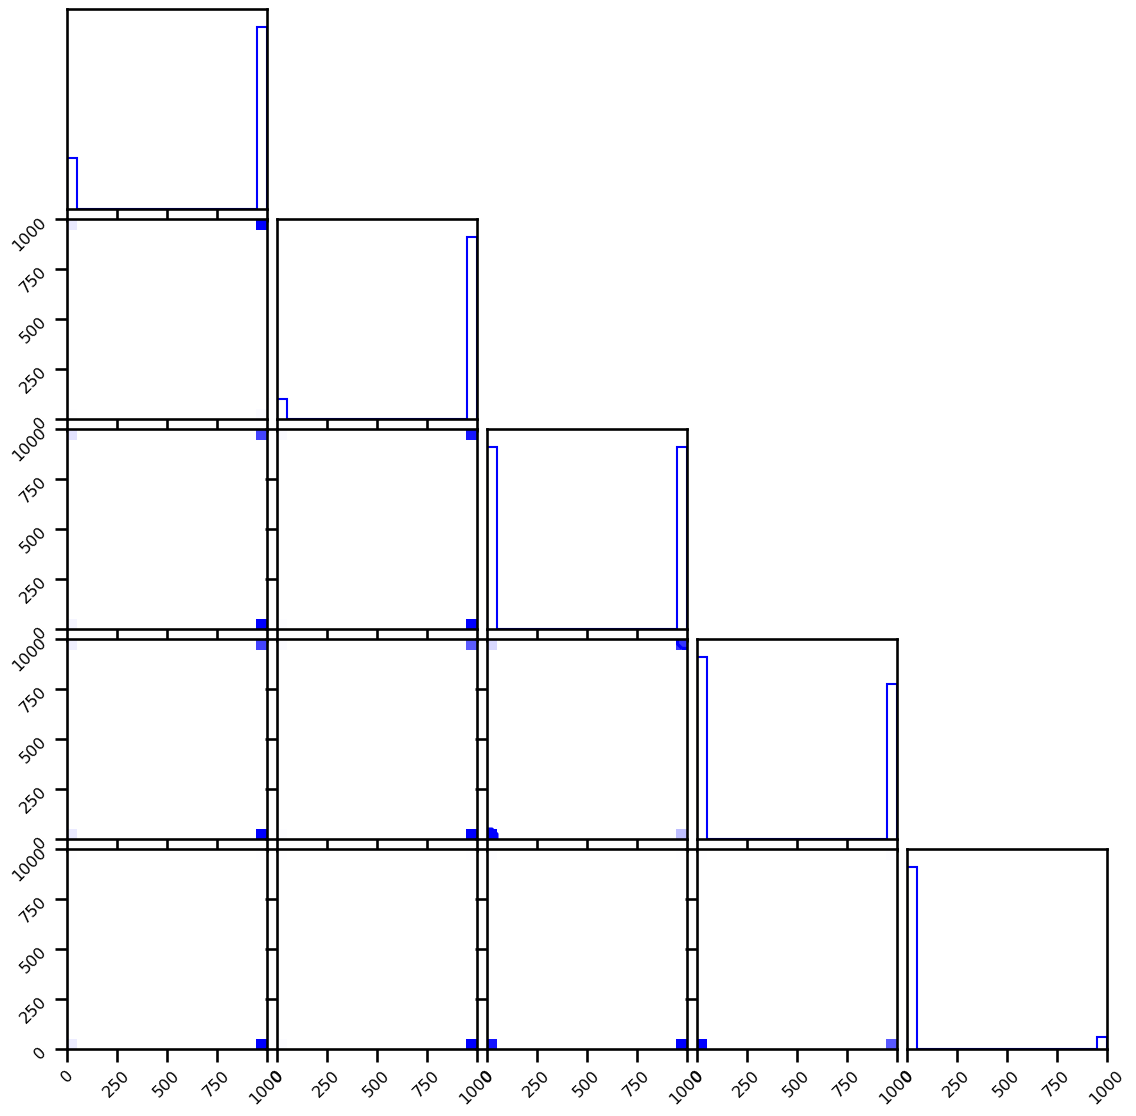

In [100]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

wandb.log({"generated_samples_histogram": wandb.Image(plt)})

## Each Layer

#### Original

In [ ]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    

#### Trained Model

In [ ]:

X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [101]:
import joblib

#### Save Model

In [102]:
model_save_name = os.path.join(wandb.run.dir, "gf_model.pckl")
joblib.dump(gf_model, model_save_name)
wandb.save(model_save_name)

['gf_model_mnist.pickle']

#### Load Model

In [103]:
gf_model_ = joblib.load(model_save_name)